In [1]:
# This is just an example of how to prepare the Jupyter notebook for plotting and is not strictly necessary.
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = [12, 6]
from matplotlib.figure import Figure
from matplotlib.axes import Axes

from IPython.display import (
    Latex,
    Markdown,
    Math,
    display,
)

# Some imports to help with type annotations and other things later on.
from time import time
from typing import (
    Dict,
    List,
    Optional,
    Tuple,
    Type,
)
from pandas import DataFrame
from lmfit import fit_report
from numpy import (
    array,
    ndarray,
    inf,
    log10 as log,
    logspace,
)
from numpy.random import (
    seed,
    normal,
)
seed(42)

# Getting started with _pyimpspec_

In [2]:
import pyimpspec  # Imports the top-level API.
from pyimpspec.plot import mpl  # Imports functions for plotting pyimpspec's various objects using matplotlib.
# Additional imports for more convenient type annotations
from pyimpspec import (
    Circuit,
    Element,
    DataSet,
    DRTResult,
    FitResult,
    TestResult,
)

# Experimental data

## Loading experimental data

Loading experimental data can be done with the `parse_data` function, which is a wrapper for the various file format parsers.
Some of the supported file formats may contain multiple spectra in a single file and thus the `parse_data` function always returns a list of `DataSet` objects.

In [3]:
spectra: List[DataSet] = pyimpspec.parse_data("./example-data.csv")
spectrum: DataSet = spectra[0]
spectrum.set_label("Ideal")

## Plotting impedance spectra

The `plot_data` function provides a quick way to plot an impedance spectrum as both Nyquist (right) and Bode (left) plots.

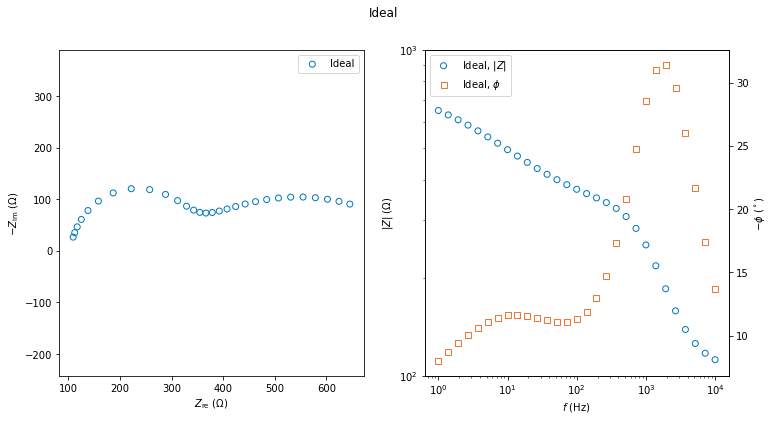

In [4]:
fig, axes = mpl.plot_data(spectrum)

The `plot_data` function makes use of the `plot_nyquist` and `plot_bode` functions, which can be used directly.
There are also several other primitive plotting functions (`plot_real_impedance`, `plot_impedance_magnitude`, etc.).

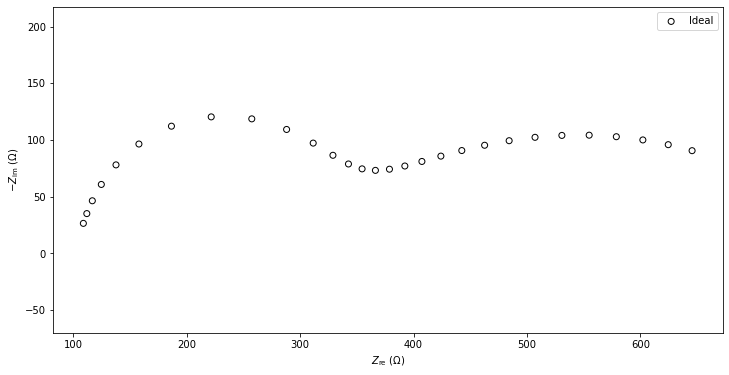

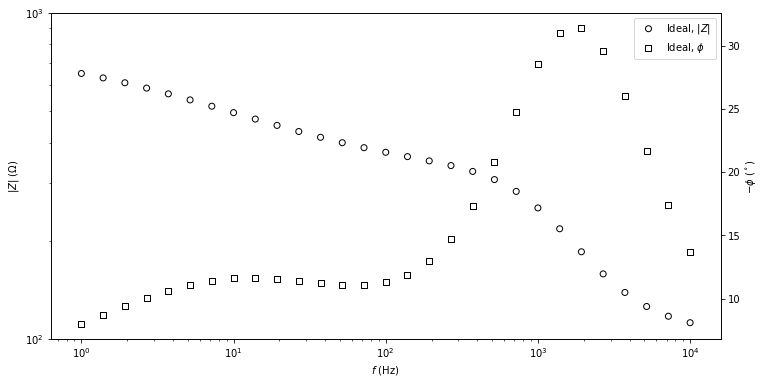

In [5]:
_, _ = mpl.plot_nyquist(spectrum)
_, _ = mpl.plot_bode(spectrum)

## Dealing with outliers

Individual data points can be masked (i.e., omitted) by applying a mask, which is simply a dictionary with zero-based integer indices as keys and boolean values.
`True` means that the data point is masked/omitted.

Number of points (disregarding any masked points): 27
Number of unmasked points: 27
Number of masked points: 2
Number of points in total: 29


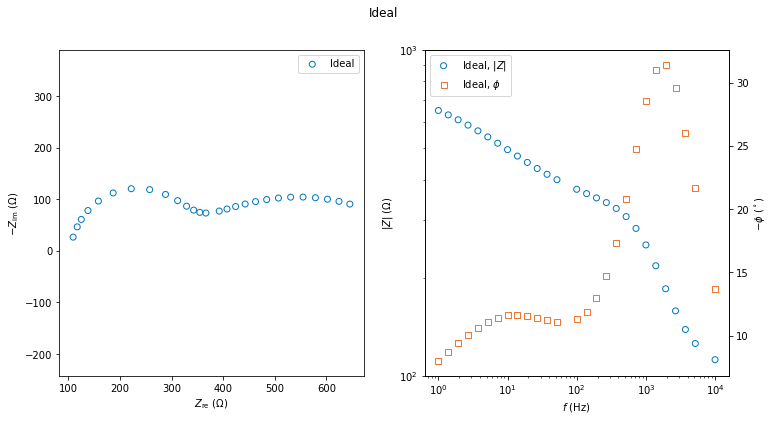

In [6]:
spectrum.set_mask({
    1: True,  # Mask the second point.
    15: True,  # Mask the sixteenth point.
})
fig, axes = mpl.plot_data(spectrum)

print(f"Number of points (disregarding any masked points): {len(spectrum.get_impedance())}")
print(f"Number of unmasked points: {len(spectrum.get_impedance(masked=False))}")
print(f"Number of masked points: {len(spectrum.get_impedance(masked=True))}")
print(f"Number of points in total: {len(spectrum.get_impedance(masked=None))}")

## Subtracting impedances

The `subtract_impedance` method accepts a single complex value or a list (or a _numpy_ array) of complex values, and can be used to, e.g., make corrections.

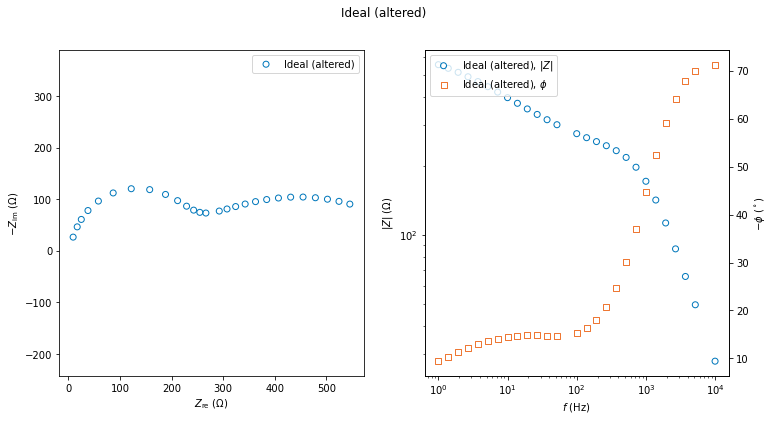

In [7]:
altered_spectrum: DataSet = DataSet.copy(spectrum, label="Ideal (altered)")
altered_spectrum.subtract_impedance(complex(100, 0))
fig, axes = mpl.plot_data(altered_spectrum)

## Averaging noisy spectra

Multiple noisy spectra can be averaged to generate a single `DataSet` object.

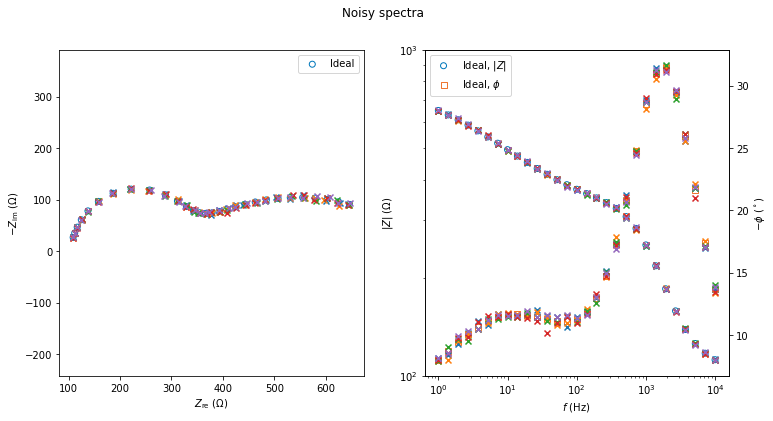

In [8]:
spectrum.set_mask({})  # Reset the mask
fig, axes = mpl.plot_data(spectrum)
fig.suptitle("Noisy spectra")

# First we create several noisy versions of the original DataSet for demonstration purposes.
noisy_spectra: List[DataSet] = []
i: int
for i in range(0, 5):
    sd: float = 0.005
    Z: complex
    noise: ndarray = array(list(map(lambda Z: complex(
        abs(Z) * normal(0, sd, 1),
        abs(Z) * normal(0, sd, 1),
    ), spectrum.get_impedance(masked=None))))  # Get all of the data points regardless of the applied mask.
    noisy_spectra.append(DataSet.copy(spectrum, label=f"Noisy ({i + 1})"))  # Create a copy of the original DataSet.
    noisy_spectra[-1].subtract_impedance(-noise)  # Add noise to the new DataSet.
    axes[0].scatter(*noisy_spectra[-1].get_nyquist_data(), marker="x")
    x, y1, y2 = noisy_spectra[-1].get_bode_data()
    axes[1].scatter(x, y1, marker="x")
    axes[2].scatter(x, y2, marker="x")

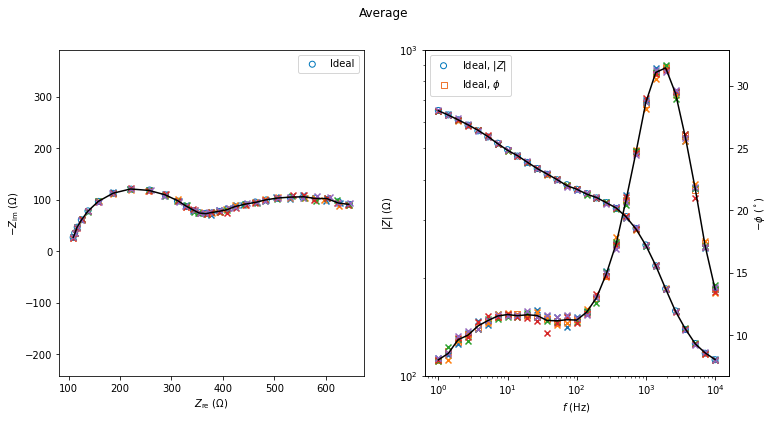

In [9]:
# Now we average the noisy spectra to create one averaged spectrum.
average: DataSet = DataSet.average(noisy_spectra)
axes[0].plot(*average.get_nyquist_data(), color="black")
x, y1, y2 = average.get_bode_data()
axes[1].plot(x, y1, color="black")
axes[2].plot(x, y2, color="black")
fig.suptitle("Average")
fig

# Kramers-Kronig tests

## Performing a test

Checking whether or not an impedance spectrum is Kramers-Kronig transformable is a common way to check the validity of an impedance spectrum.
The `perform_test` function is capable of performing different implementations of the linear Kramers-Kronig test based on the arguments that are passed to the function.
By default the complex test[[1]](https://iopscience.iop.org/article/10.1149/1.2044210/meta) is used and the number of RC elements connected in series is determined based on the µ-criterion[[2]](https://www.sciencedirect.com/science/article/abs/pii/S0013468614001005).
However, it is possible to specify another test and/or the number of RC elements to use.

In [10]:
mu_criterion: float = 0.85
test: TestResult = pyimpspec.perform_test(average, add_capacitance=True, mu_criterion=mu_criterion)

The `plot_fit` function can be used to visualize the results since that is essentially what the linear Kramers-Kronig test does (i.e., a circuit, which is known _a priori_ to be Kramers-Kronig transformable, is fitted to the experimental data).
The figure contains Nyquist and Bode plots, and a plot of the residuals.

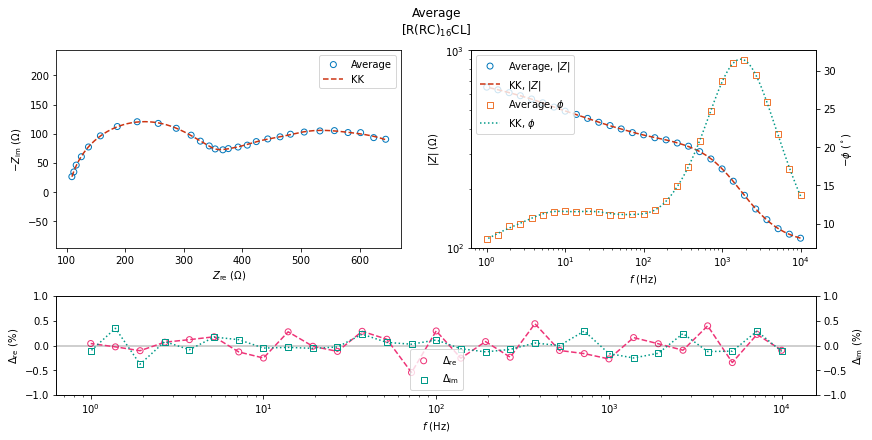

In [11]:
fig, axes = mpl.plot_fit(test, average)

Multiple test results can also be acquired by using the `perform_exploratory_tests` function instead of the `perform_test` function.
These results can then be visualized using the `plot_exploratory_tests` function.
This should make it easier to figure out if a result returned by `perform_test` is erroneous due to the underlying procedure[[2]](https://www.sciencedirect.com/science/article/abs/pii/S0013468614001005) stopping at a number of RC elements that is too low to ever properly fit a given impedance spectrum.
This can sometimes happen if µ fluctuates wildly enough at low numbers of RC elements.

In the example below, `perform_test` returns a result with only two RC elements while the `perform_exploratory_tests` suggests fifteen RC elements despite using the same settings.
The `perform_exploratory_tests` returns a list of results that have been scored and then sorted from best to worst (i.e., the highest-scoring result is the first element).
Close proximity to the µ-criterion (as long as µ is below the µ-criterion) and a small χ² contribute to a high score.

Num. RC: 2, mu: 0.846, log pseudo chi-squared: 0.71
Num. RC: 15, mu: 0.786, log pseudo chi-squared: -3.54


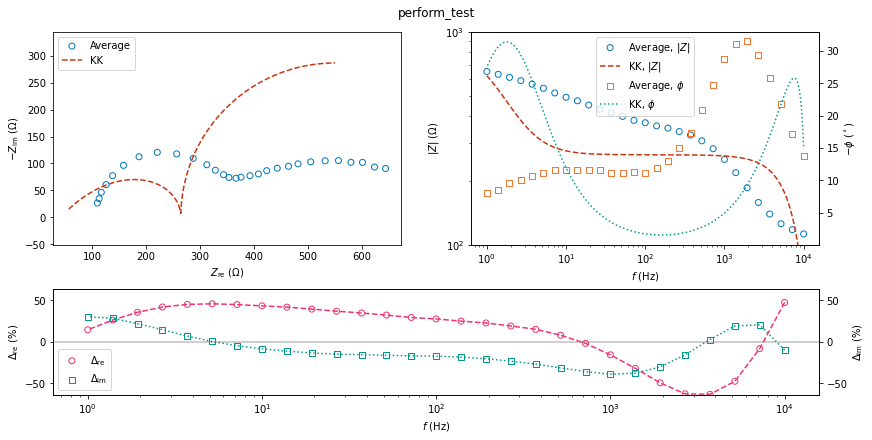

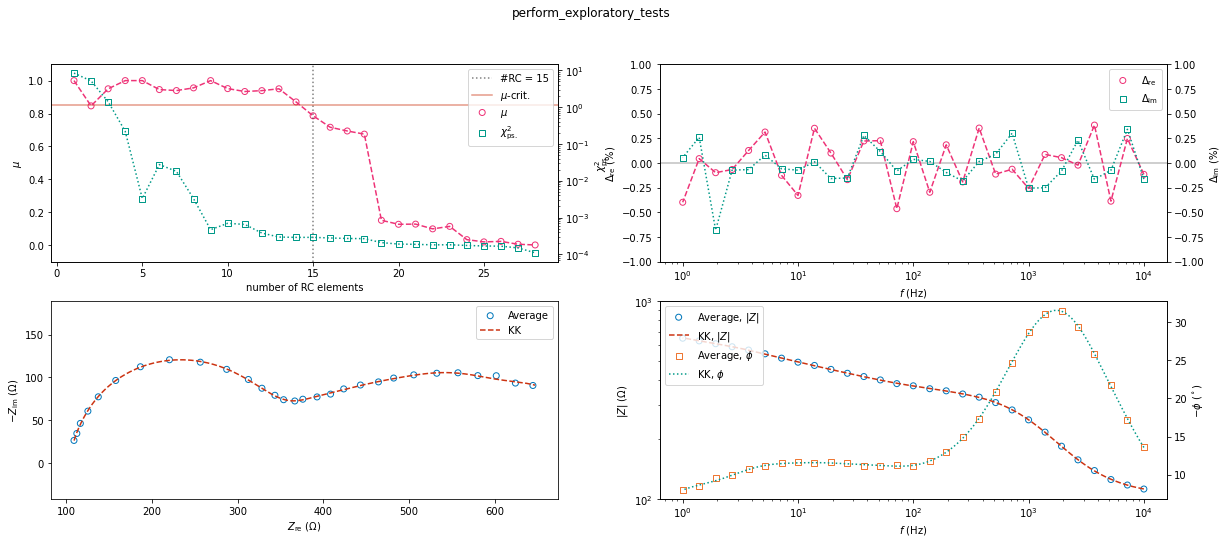

In [12]:
mu_criterion = 0.85
test = pyimpspec.perform_test(average, mu_criterion=mu_criterion)
fig, axes = mpl.plot_fit(test, average, title="perform_test")
print(f"Num. RC: {test.num_RC}, mu: {test.mu:.3f}, log pseudo chi-squared: {log(test.pseudo_chisqr):.2f}")

matplotlib.rcParams["figure.figsize"] = [20, 8]
results: List[TestResult] = pyimpspec.perform_exploratory_tests(average, mu_criterion=mu_criterion)
fig, axes = mpl.plot_exploratory_tests(results, mu_criterion, average, title="perform_exploratory_tests")
test = results[0]
print(f"Num. RC: {test.num_RC}, mu: {test.mu:.3f}, log pseudo chi-squared: {log(test.pseudo_chisqr):.2f}")
matplotlib.rcParams["figure.figsize"] = [12, 6]

# Equivalent circuit fitting

## Creating equivalent circuits

A routine part of analyzing impedance spectra is to perform complex non-linear least squares (CNLS) fitting of equivalent circuits to the spectra.
The easiest way to construct an equivalent circuit with _pyimpspec_ is by letting _pyimpspec_ parse a circuit description code (CDC).
CDCs are used in many different programs that are made for analyzing impedance spectra and the syntax is similar across most of those programs.
Square brackets (`[]`) represent elements connected in series and parentheses (`()`) represent elements connected in parallel.
The various elements have their own symbols:

In [13]:
elements: Dict[str, Type[Element]] = pyimpspec.get_elements()
elements

{'C': pyimpspec.circuit.capacitor.Capacitor,
 'G': pyimpspec.circuit.gerischer.Gerischer,
 'H': pyimpspec.circuit.havriliak_negami.HavriliakNegami,
 'L': pyimpspec.circuit.inductor.Inductor,
 'Ls': pyimpspec.circuit.de_levie.DeLevieFiniteLength,
 'Q': pyimpspec.circuit.constant_phase_element.ConstantPhaseElement,
 'R': pyimpspec.circuit.resistor.Resistor,
 'W': pyimpspec.circuit.warburg.Warburg,
 'Wo': pyimpspec.circuit.warburg.WarburgOpen,
 'Ws': pyimpspec.circuit.warburg.WarburgShort}

Some information about the elements and their parameters can be obtained as follows:

In [14]:
print(elements["Q"].get_extended_description())

Constant phase element

Symbol: Q

Z = 1/(Y*(j*2*pi*f)^n)

Variables
---------
Y: float = 1E-6 (F*s^(n-1))
n: float = 0.95


The corresponding SymPy expression and $\rm \LaTeX$ math equations can be generated as follow:

In [15]:
cpe: pyimpspec.ConstantPhaseElement = pyimpspec.ConstantPhaseElement()
print(f"""
SymPy expression: {cpe.to_sympy()}

LaTeX math equation: {cpe.to_latex()}

Rendered LaTeX math equation:
""".strip())
display(Math(cpe.to_latex()))

SymPy expression: 1/(Y*(2*I*pi*f)**n)

LaTeX math equation: Z = \frac{\left(2 i \pi f\right)^{- n}}{Y}

Rendered LaTeX math equation:


<IPython.core.display.Math object>

One way of creating a circuit is to use the `parse_cdc` function:

In [16]:
circuit: Circuit = pyimpspec.parse_cdc("R(RC)(RW)")
print(circuit.to_string())

[R(RC)(RW)]


Initial values and limits can be included using the extended CDC syntax (see one of the sections below for more information).

Alternatively, the `CircuitBuilder` class can be used to create a circuit:

In [17]:
with pyimpspec.CircuitBuilder() as builder:
    builder += pyimpspec.Resistor()
    # Alternatively, builder.add(pyimpspec.Resistor())
    with builder.parallel() as parallel:
        parallel += pyimpspec.Resistor()
        parallel += pyimpspec.Capacitor()
    with builder.parallel() as parallel:
        parallel += pyimpspec.Resistor()
        parallel += pyimpspec.Warburg()
circuit = builder.to_circuit()
print(circuit.to_string())

[R(RC)(RW)]


This type of circuit was used to generate the first impedance spectrum in this notebook albeit with different values for the resistances, capacitances, etc.

The impedance response of a circuit can be plotted with the `plot_circuit` function.

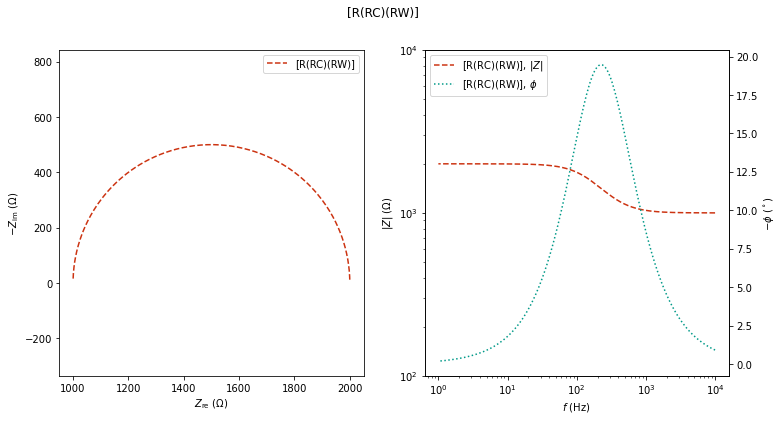

In [18]:
matplotlib.rcParams["figure.figsize"] = [12, 6]
fig, axes = mpl.plot_circuit(circuit, f=logspace(0, 4, num=41 * 5))

The SymPy expression and $\rm \LaTeX$ math equation can also be obtained for the circuit:

In [19]:
print(f"""
SymPy expression: {circuit.to_sympy()}

LaTeX math equation: {circuit.to_latex()}

Rendered LaTeX math equation:
""".strip())
display(Math(circuit.to_latex()))

SymPy expression: R_0 + 1/(2*I*pi*C_2*f + 1/R_1) + 1/(sqrt(2)*sqrt(pi)*Y_4*sqrt(I*f) + 1/R_3)

LaTeX math equation: Z = R_{0} + \frac{1}{2 i \pi C_{2} f + \frac{1}{R_{1}}} + \frac{1}{\sqrt{2} \sqrt{\pi} Y_{4} \sqrt{i f} + \frac{1}{R_{3}}}

Rendered LaTeX math equation:


<IPython.core.display.Math object>

## Fitting a circuit to a data set

An equivalent circuit can be fitted to an impedance spectrum with the `fit_circuit` function.
The returned `FitResult` object contains among other things a reference to a copy of the original circuit that has had its various parameters fitted.
The [`lmfit.minimizer.MinimizerResult`](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.MinimizerResult) produced during fitting is also included in the `FitResult` object.

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 54
    # data points      = 58
    # variables        = 5
    chi-square         = 4.7034e-09
    reduced chi-square = 8.8744e-11
    Akaike info crit   = -1337.65427
    Bayesian info crit = -1327.35206
[[Variables]]
    Y_4:  3.9972e-04 +/- 1.7997e-06 (0.45%) (init = 1)
    R_3:  501.222680 +/- 1.55701445 (0.31%) (init = 1000)
    C_2:  8.0128e-07 +/- 1.4349e-09 (0.18%) (init = 1e-06)
    R_1:  199.588625 +/- 0.36767854 (0.18%) (init = 1000)
    R_0:  100.006084 +/- 0.10974649 (0.11%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(Y_4, R_1) = 0.857
    C(Y_4, R_0) = 0.558
    C(Y_4, R_3) = 0.426
    C(R_1, R_0) = 0.309
    C(C_2, R_0) = 0.255
    C(R_3, R_0) = 0.211
    C(R_3, R_1) = 0.182


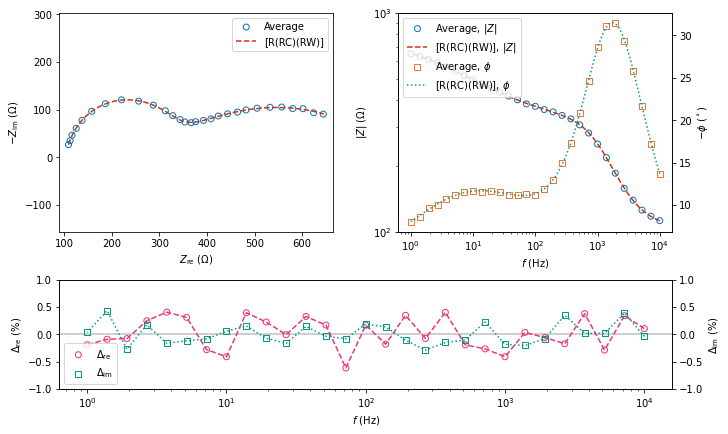

In [20]:
matplotlib.rcParams["figure.figsize"] = [10, 6]
fit: FitResult = pyimpspec.fit_circuit(circuit, average)
fig, axes = mpl.plot_fit(fit, average)
print(fit_report(fit.minimizer_result))

Information about the fitted parameters can also be output in various formats by creating a `pandas.DataFrame` object.
Below is an example of a raw $\rm \LaTeX$ table and a rendered Markdown table.

In [21]:
print(fit.to_dataframe().to_latex(index=False, float_format="%.3g"))
display(Markdown(fit.to_dataframe().to_markdown(index=False, floatfmt=".3g")))

\begin{tabular}{llrrl}
\toprule
Element & Parameter &    Value &  Std. err. (\%) & Fixed \\
\midrule
    R\_0 &         R &      100 &           0.11 &    No \\
    R\_1 &         R &      200 &          0.184 &    No \\
    C\_2 &         C & 8.01e-07 &          0.179 &    No \\
    R\_3 &         R &      501 &          0.311 &    No \\
    W\_4 &         Y &   0.0004 &           0.45 &    No \\
\bottomrule
\end{tabular}



/tmp/ipykernel_19564/3082030151.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(fit.to_dataframe().to_latex(index=False, float_format="%.3g"))


| Element   | Parameter   |      Value |   Std. err. (%) | Fixed   |
|:----------|:------------|-----------:|----------------:|:--------|
| R_0       | R           | 100        |           0.11  | No      |
| R_1       | R           | 200        |           0.184 | No      |
| C_2       | C           |   8.01e-07 |           0.179 | No      |
| R_3       | R           | 501        |           0.311 | No      |
| W_4       | Y           |   0.0004   |           0.45  | No      |

## Setting the initial values of elements

`fit_circuit` has several parameters and by default the function tries several of the methods supported by [_lmfit_](https://lmfit.github.io/lmfit-py/fitting.html) as well as the various weight functions implemented in _pyimpspec_.
However, it may be necessary to modify the initial values and limits of parameters before performing a fit in order to achieve a good fit.
_pyimpspec_ supports an extended CDC syntax that allows you to specify the initial values and lower and/or upper limits of parameters, and element labels.

For example, the elements in the circuit created in the next cell can be broken down as follows.

`R{R=50/50%:sol}`

Set the initial value of the `R` parameter at 50 ohms, the lower limit at 50 % of the initial value, and omit the upper limit.
Set `sol` as the element label.

`C{C=1e-6/1e-8/1e-4:dl}`

Set the initial value of the `C` parameter at 1 µF, the lower limit at 10 nF, and the upper limit at 100 µF.
Set `dl` as the element label.

`R{R=800f:ct}`

Set the initial value of the `R` parameter at 800 ohms and make it a fixed value.
Set `ct` as the element label.

`W{Y=2.3e-4//1e-3}`

Set the initial value of the `Y` parameter at 0.23 mS\*s^(1/2), omit the lower limit, and set the upper limit at 1 mS\*s^(1/2).
Use the default label, which is the zero-based index assigned to the element.

[R{R=5.0E+01/2.5E+01:sol}(C{C=1.0E-06/1.0E-08/1.0E-04:dl}[R{R=8.0E+02F:ct}W{Y=2.3E-04//1.0E-03}])]


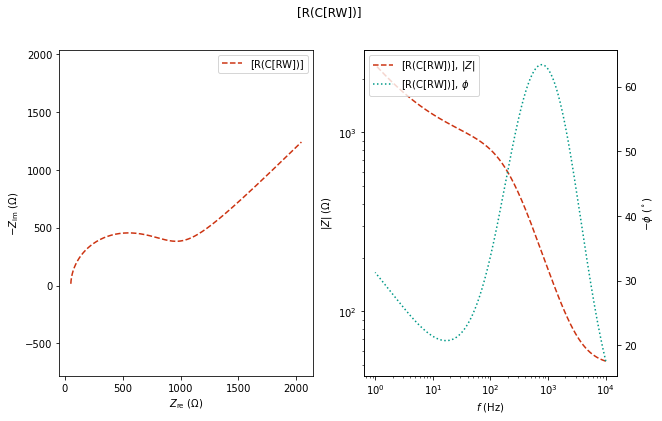

In [22]:
circuit = pyimpspec.parse_cdc("R{R=50/50%:sol}(C{C=1e-6/1e-8/1e-4:dl}[R{R=800f:ct}W{Y=2.3e-4//1e-3}])")
print(circuit.to_string(1))
# Use the frequency range in the DataSet object (adding a visible_data=True argument would also plot the DataSet).
fig, axes = mpl.plot_circuit(circuit, data=average)

The corresponding circuit can be created using the `CircuitBuilder` class as follows:

[R{R=5.0E+01/2.5E+01:sol}(C{C=1.0E-06/1.0E-08/1.0E-04:dl}[R{R=8.0E+02F:ct}W{Y=2.3E-04//1.0E-03}])]


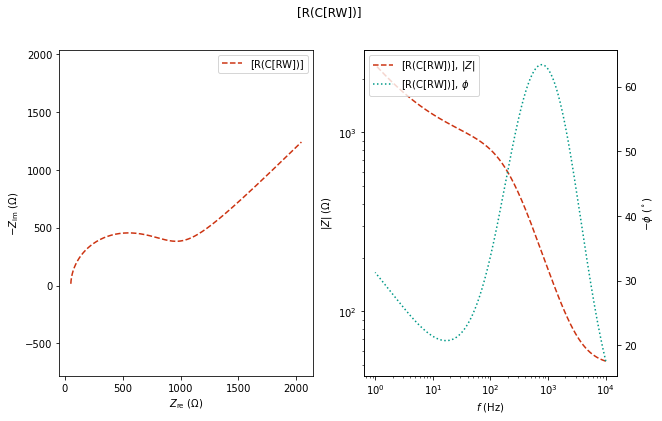

In [23]:
with pyimpspec.CircuitBuilder() as builder:
    builder += (
        pyimpspec.Resistor(R=50)
        .set_label("sol")
        .set_lower_limit("R", 0.5 * 50)
    )
    with builder.parallel() as parallel:
        parallel += (
            pyimpspec.Capacitor(C=1e-6)
            .set_label("dl")
            .set_lower_limit("C", 1e-8)
            .set_upper_limit("C", 1e-4)
        )
        with parallel.series() as series:
            series += (
                pyimpspec.Resistor(R=800)
                .set_fixed("R", True)
                .set_label("ct")
            )
            series += (
                pyimpspec.Warburg(Y=2.3e-4)
                .set_lower_limit("Y", -inf)
                .set_upper_limit("Y", 1e-3)
            )
circuit = builder.to_circuit()
print(circuit.to_string(1))
fig, axes = mpl.plot_circuit(circuit, data=average)

## Circuit diagrams

There are two approaches to drawing a circuit diagram:
- generate $\rm \LaTeX$ source for inclusion in a $\rm \LaTeX$ document that makes use of the [_circuitikz_](https://ctan.org/pkg/circuitikz) package
- generate a `schemdraw.Drawing` object that can be used to draw the diagram using, e.g., the `matplotlib` backend

In [24]:
print(circuit.to_circuitikz())

\begin{circuitikz}
	\draw (0,0) node[above]{WE} to[short, o-] (1,0);
	\draw (1.0,0.0) to[R=$R_{\rm sol}$] (3.0,0.0);
	\draw (3.0,-0.0) to[capacitor=$C_{\rm dl}$] (5.0,-0.0);
	\draw (3.0,-1.5) to[R=$R_{\rm ct}$] (5.0,-1.5);
	\draw (5.0,-1.5) to[generic=$W_{\rm 3}$] (7.0,-1.5);
	\draw (3.0,-0.0) to[short] (3.0,-1.5);
	\draw (7.0,-0.0) to[short] (7.0,-1.5);
	\draw (5.0,-0.0) to[short] (7.0,-0.0);
	\draw (7.0,0) to[short, -o] (8.0,0) node[above]{CE+RE};
\end{circuitikz}


Here's how it looks after rendering with $\rm \LaTeX$.

![circuitikz](circuitikz-example.png)

And here is the corresponding result produced with `schemdraw.Drawing`.

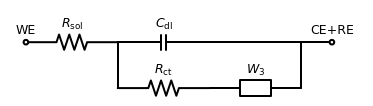

In [25]:
circuit.to_drawing()

# Customizing plots

The various `plot_*` functions return a `matplotlib.figure.Figure` object and one or more `matplotlib.axes.Axes` objects.
A set of figure and axes can be supplied to those functions in case you wish to use a different layout.
The returned figure and axis/axes can in either case be used to further alter the plots (e.g., adding legends).
Aside from the `plot_data`, `plot_fit`, `plot_exploratory_tests`, and `plot_circuit` functions, there are also functions for the individual subplots (i.e., `plot_nyquist`, `plot_bode`, etc.) that are used by the functions that were listed earlier.

The example below shows how one could go about removing legends or customizing the placement of legends in the various subplots of the figure produced by the `plot_fit` function.

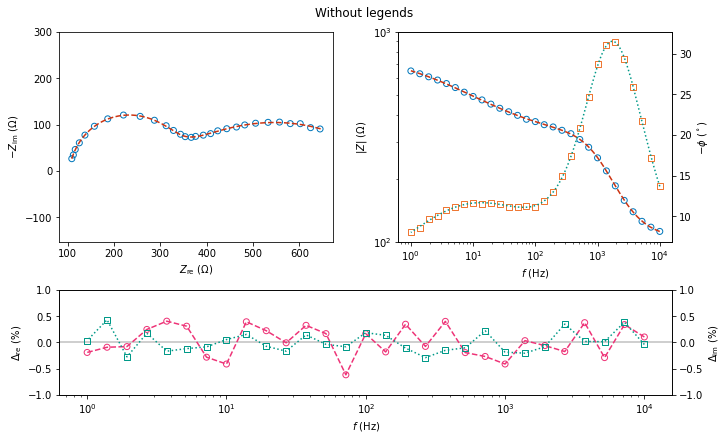

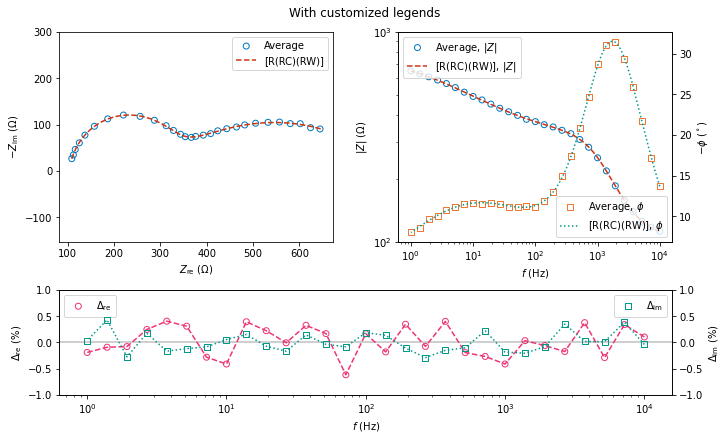

In [26]:
fig, axes = mpl.plot_fit(fit, average, legend=False, title="Without legends")
fig, axes = mpl.plot_fit(fit, average, legend=False, title="With customized legends")
axes[0].legend(loc="upper right")  # Nyquist plot.
axes[1].legend(loc="upper left")  # Bode plot - base-10 logarithm of the absolute magnitude.
axes[2].legend(loc="lower right")  # Bode plot - negative phase shift.
axes[3].legend(loc="upper left")  # Residuals plot - residuals of the real parts.
axes[4].legend(loc="upper right")  # Residuals plot - residuals of the imaginary parts.

# Calculating the distribution of relaxation times

Multiple implementations for calculating the distribution of relaxation times (DRT) are included in _pyimpspec_.
DRT can in the best case be used to identify the number of time constants actually present in an impedance spectrum and the corresponding numerical values.
In some cases the number of time constants can be identified from a Nyquist plot.
For example, if two or more time constants are clearly separated, then this can also be observed in a Nyquist plot.
However, sometimes the time constants are not far apart from one another and produce a Nyquist plot that might look like there is only one time constant.
Knowledge of the (likely) number of time constants can also be useful when developing an equivalent circuit.

**NOTE!** Calculating DRTs is an ill-posed problem so some tweaking of the settings and possibly also seeding of the pseudo-random number generator may be required to get reasonable and consistent results.

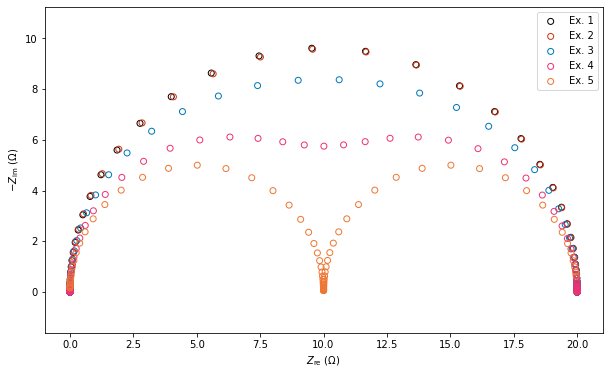

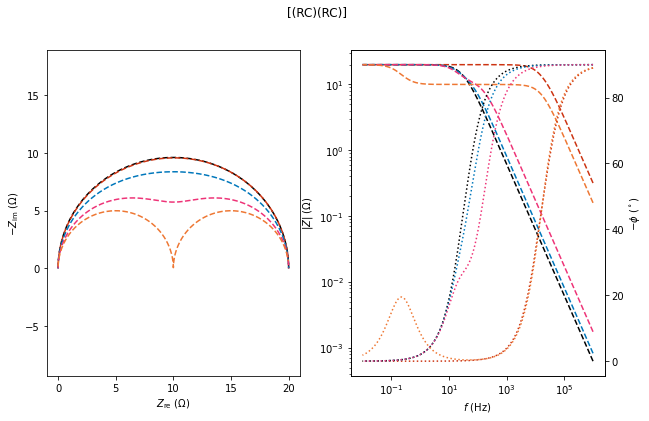

In [27]:
seed(28041948)  # GNU STP


def plot_examples(f: ndarray, CDCs: List[str], colors: List[str], title: str = "", **kwargs):
    lines: List[str] = []
    labels: List[str] = []
    durations: List[float] = []
    drt_fig: Optional[Figure] = None
    drt_axis: Optional[Axes] = None
    i: int
    cdc: str
    color: str
    for i, (cdc, color) in enumerate(zip(CDCs, colors)):
        data: DataSet = pyimpspec.simulate_spectrum(
            pyimpspec.parse_cdc(cdc),
            f,
            label=f"Ex. {i + 1}",
        )
        labels.append(data.get_label())
        start: float = time()
        drt: DRTResult = pyimpspec.calculate_drt(data, **kwargs)
        durations.append(time() - start)
        drt_fig, drt_axis = mpl.plot_gamma(
            drt,
            color=color,
            label=f"{data.get_label()} ({kwargs['method']})",
            fig=drt_fig,
            axis=drt_axis,
        )
        drt_fig.suptitle(title)
    drt_axis.set_xlim(min(1 / f), max(1 / f))
    drt_axis.set_ylim(-10, 60)
    # How long did it take to do the calculations?
    #lines.extend(map(lambda i: f"- {labels[i]} took {(durations[i]):.2f} seconds...", range(0, len(durations))))
    #lines.insert(0, f"Total: {sum(durations):.2f} seconds")
    #lines.append("")
    #print("\n".join(lines))


CDCs: List[str] = [
    "(R{R=10}C{C=7e-4})(R{R=10}C{C=4e-4})",
    "(R{R=7}C)(R{R=13}C)",
    "(R{R=10}C{C=8.5e-4})(R{R=10}C{C=2.5e-4})",
    "(R{R=10}C{C=1e-3})(R{R=10}C{C=1e-4})",
    "(R{R=10}C{C=1e-1})(R{R=10}C{C=1e-6})",
]

colors: List[str] = [
    "#000000",
    "#CC3311",
    "#0077BB",
    "#EE3377",
    "#EE7733",
]

f: ndarray = logspace(-2, 6, num=(8 * 10) + 1)

nyquist_fig: Optional[Figure] = None
nyquist_axis: Optional[Axes] = None
fig: Optional[Figure] = None
axes: List[Axes] = []
i: int
cdc: str
color: str
for i, (cdc, color) in enumerate(zip(CDCs, colors)):
    data: DataSet = pyimpspec.simulate_spectrum(pyimpspec.parse_cdc(cdc), f, label=f"Ex. {i + 1}")
    nyquist_fig, nyquist_axis = mpl.plot_nyquist(data, color=color, fig=nyquist_fig, axis=nyquist_axis)
    fig, axes = mpl.plot_circuit(
        pyimpspec.parse_cdc(cdc),
        min_f=min(f),
        max_f=max(f),
        label=f"Ex. {i + 1}",
        legend=False,
        color_nyquist=color,
        color_bode_magnitude=color,
        color_bode_phase=color,
        fig=fig, axes=axes,
    )

## Different methods

Below are examples of the different DRT methods with some of the method-specific settings.
The keywords arguments passed to the `plot_examples` function are passed on to the `pyimpspec.calculate_drt` function.
Note that not all of the available settings are demonstrated here.
See the API documentation for information about all of the available settings.

### TR-NNLS

Tikhonov regularization combined with non-negative least squares. This method is fast.

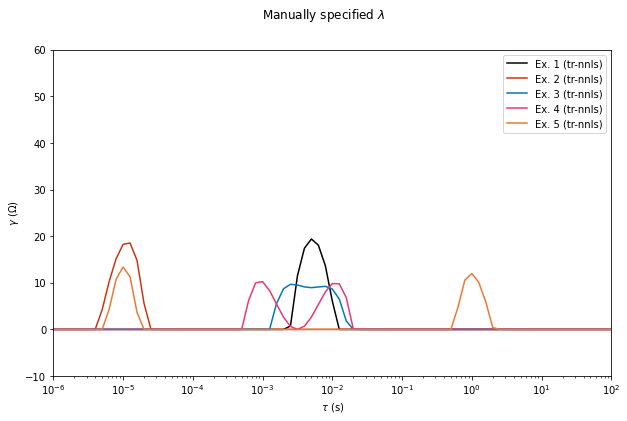

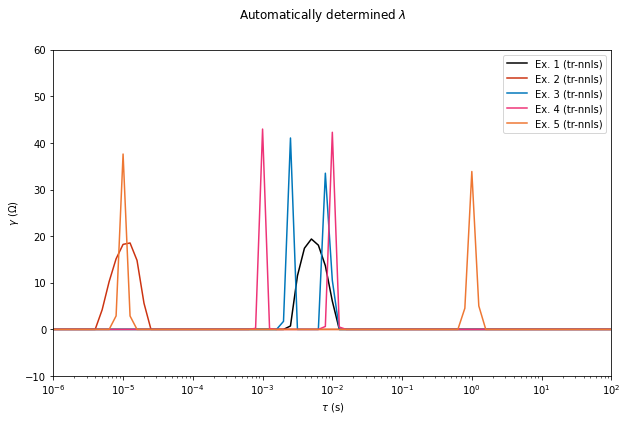

In [28]:
plot_examples(
    f,
    CDCs,
    colors,
    title=r"Manually specified $\lambda$",
    method="tr-nnls",
    # Specify that the real part of the data should be used (default value for this setting).
    # This method only supports "real" and "imaginary".
    mode="real",
    # The regularization parameter (lambda) can be adjusted manually. A large value may
    # result in two nearby peaks to show up as a single broad peak.
    lambda_value=1e-2,
)

plot_examples(
    f,
    CDCs,
    colors,
    title=r"Automatically determined $\lambda$",
    method="tr-nnls",
    # Specify that the real part of the data should be used (default value for this setting).
    # This method only supports "real" and "imaginary".
    mode="real",
    # Setting lambda_value at zero or below results in an automated attempt to find a suitable
    # value. This can be used as a starting point before tweaking the value further.
    lambda_value=0.0,
)

### TR-RBF

Tikhonov regularization combined with radial basis function (or piecewise linear) discretization. This method is slower than `tr-nnls`, particularly if the Bayesian credible interval is also calculated.

Note that if the plots below look different on your system after running the following cell, then that may be due whether or not _CVXPY_ was installed as an optional dependency.

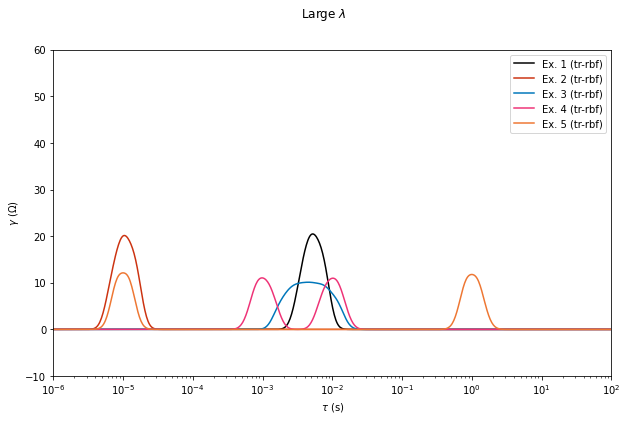

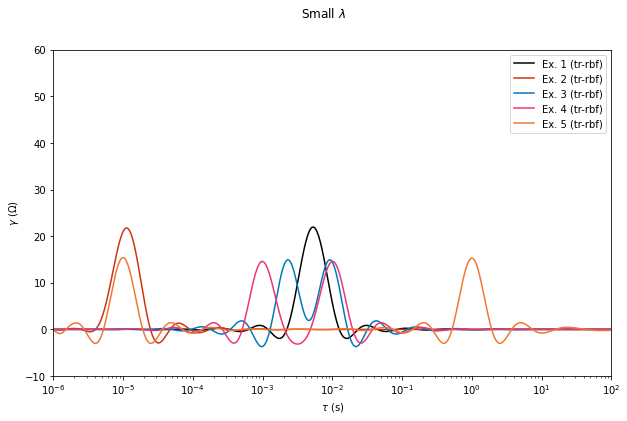

In [29]:
plot_examples(
    f,
    CDCs,
    colors,
    title=r"Large $\lambda$",
    method="tr-rbf",
    # This method supports using the complex data or only the real/imaginary part of the data.
    mode="complex",
    # Similarly to the "tr-nnls" method, the regularization parameter (lambda) can be set at
    # a specific value or set to zero (or below) to force an attempt to automatically find a
    # suitable value.
    lambda_value=1e-3,
)

plot_examples(
    f,
    CDCs,
    colors,
    title=r"Small $\lambda$",
    method="tr-rbf",
    # Note that a small value may result in oscillation as demonstrated here.
    lambda_value=1e-6,
)

### BHT

The Bayesian Hilbert transform method can be temperamental due to the randomization of initial values.
If using a low number of attempts, then poor results may be obtained occasionally.
Simply increase the number of attempts or redo the calculation.

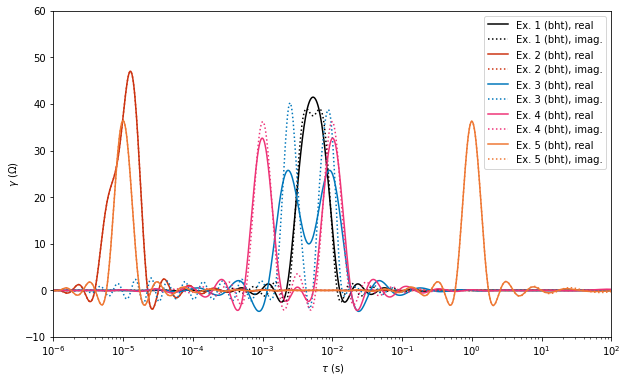

In [30]:
plot_examples(
    f,
    CDCs,
    colors,
    method="bht",
    # Specify the number of attempts that each process should make. A larger number
    # should provide better results but may take a lot longer.
    num_attempts=50,
    # The maximum vertical peak-to-peak symmetry, which is used as a descriptor for
    # strong oscillations, can be used to discard results with too much vertical symmetry.
    # The value is ratio (0.0 to 1.0) and the smaller the value, the stricter the condition.
    maximum_symmetry=0.5,
    # Specify the number of samples to use. More samples should provide more accurate
    # results at the expense of time.
    num_samples=10000,
)

## Peaks

The time constants corresponding to the peaks can be obtained as shown below.

tau = 1e-03 s -> f = 1e+03 Hz
tau = 4e+01 s -> f = 2e-02 Hz

\begin{tabular}{rr}
\toprule
$\tau$ (s) & $\gamma\ (\Omega)$ \\
\midrule
   1.0e-03 &                 43 \\
   1.0e-02 &                 42 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_19564/222809255.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(drt.to_dataframe(threshold=0.1, latex_labels=True).to_latex(


|   tau (s) |   gamma (ohms) |
|----------:|---------------:|
|   1.0e-03 |             43 |
|   1.0e-02 |             42 |

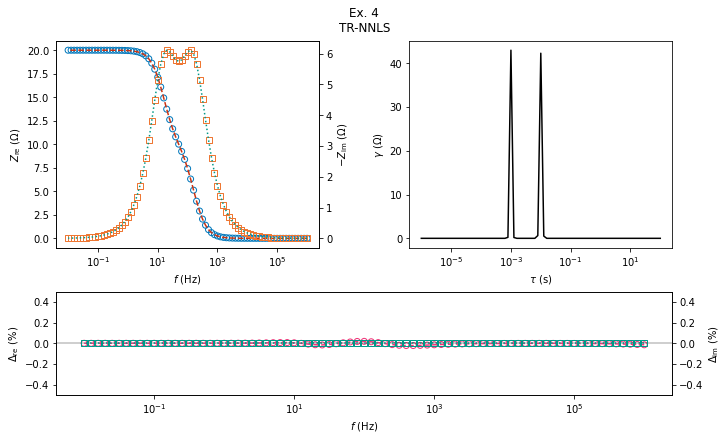

In [31]:
i: int = 3
data: DataSet = pyimpspec.simulate_spectrum(
    pyimpspec.parse_cdc(CDCs[i]),
    f,
    label=f"Ex. {i + 1}",
)
drt: DRTResult = pyimpspec.calculate_drt(data)
_, _ = mpl.plot_drt(drt, data, legend=False)

tau: float
gamma: float
for (tau, gamma) in drt.get_peaks(threshold=0.1):
    print(f"tau = {tau:.0e} s -> f = {1 / tau:.0e} Hz")
print("")

# Generate a LaTeX table
print(drt.to_dataframe(threshold=0.1, latex_labels=True).to_latex(
    index=False,
    escape=False,
    formatters=[
        lambda _: f"{_:.1e}",
        lambda _: f"{_:.0f}"
    ],
))

# Generate and render a Markdown table
display(Markdown(drt.to_dataframe(threshold=0.1).to_markdown(index=False, floatfmt=(".1e", ".0f",))))

## Scores for data quality

The `bht` method also produces a set of scores that can be used to assess the quality of an impedance spectrum.

hellinger_distance (0.7273459787250571+0.646766424516189j)
jensen_shannon_distance (0.8892831580260067+0.794784987222624j)
mean (0.9987322809611882+0.9941950487217476j)
residuals_1sigma (0.7931034482758621+0.896551724137931j)
residuals_2sigma (1+1j)
residuals_3sigma (1+1j)


| Score                   |   Real (%) |   Imaginary (%) |
|:------------------------|-----------:|----------------:|
| Mean                    |       99.9 |            99.4 |
| Residuals, 1 sigma      |       79.3 |            89.7 |
| Residuals, 2 sigma      |      100.0 |           100.0 |
| Residuals, 3 sigma      |      100.0 |           100.0 |
| Hellinger distance      |       72.7 |            64.7 |
| Jensen-Shannon distance |       88.9 |            79.5 |

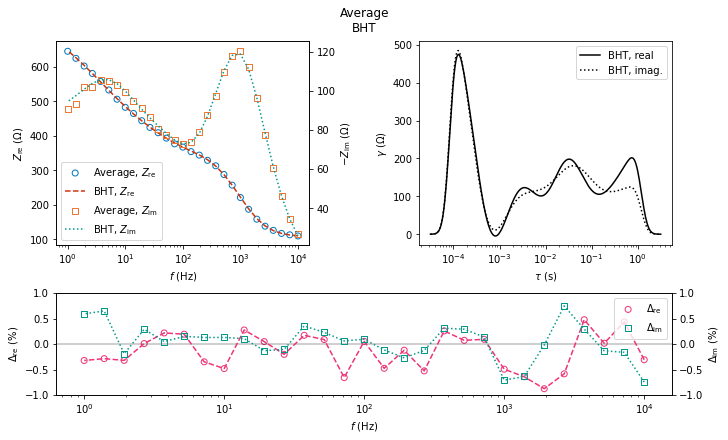

In [32]:
data: DataSet = average
drt: DRTResult = pyimpspec.calculate_drt(data, method="bht")
_, _ = mpl.plot_drt(drt, data)
list(map(lambda kv: print(*kv), drt.get_scores().items()))
display(Markdown(drt.get_score_dataframe().to_markdown(index=False, floatfmt=".1f")))

## Bayesian credible intervals

If the `tr-rbf` method is used, then the Bayesian credible intervals can be calculated.

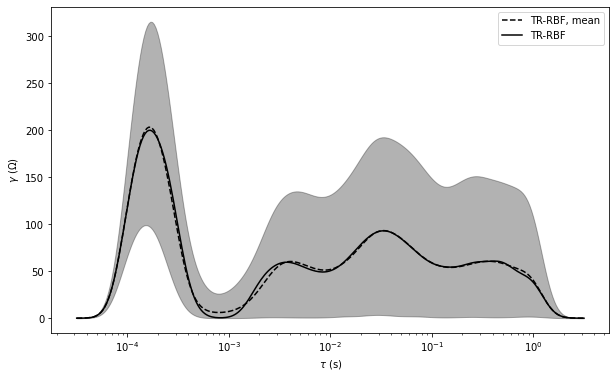

In [33]:
data: DataSet = average
drt: DRTResult = pyimpspec.calculate_drt(data, method="tr-rbf", credible_intervals=True, num_samples=1000)
_, _ = mpl.plot_gamma(drt)